In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
def load_full_df():
    main_df = pd.read_csv("processed_wildfire_ERA5_FWI.csv",index_col=0)
    main_df['date'] = pd.to_datetime(main_df['date'])
    main_df.rename(columns={'latitude_ERA5': 'latitude', 'longitude_ERA5': 'longitude'},inplace=True)
    unnamed_cols = [col for col in main_df.columns if col.startswith('Unnamed:')]
    main_df.drop(columns=unnamed_cols, inplace=True)
    main_df['type_of_high_vegetation'] = main_df['type_of_high_vegetation'].astype(int)
    main_df['type_of_low_vegetation'] = main_df['type_of_low_vegetation'].astype(int)
    return main_df

def test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.33):
    """
    Validation data is obtained by taking all data after a certain time. This is similar to model deployment.
    Train and test data are obtained using a stratified split
    """
    X_validation = validation_df.drop(columns={target_variable})
    y_validation = validation_df[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(test_train_df.drop(columns={target_variable}), 
                                                        test_train_df[target_variable], 
                                                        test_size=test_proportion,
                                                        stratify=test_train_df[target_variable], 
                                                        random_state=42)
    
    return X_train, X_test, X_validation, y_train, y_test, y_validation

In [3]:
main_df = load_full_df()

# Create the validation dataframe out of data after 2019
validation_df = main_df[main_df['date'] > pd.Timestamp('2019-01-01')]
test_train_df = main_df[main_df['date'] < pd.Timestamp('2019-01-01')]

X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.25)

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn import set_config
set_config(transform_output = "pandas")

# Define features to include #
pass_features = ['leaf_area_index_high_vegetation', 'slope_of_sub_gridscale_orography']
categorical_features = []
numeric_features = ['DMC','global_noon_LST_2m_temperature','BUI',
                'FWI','latitude','FFMC','global_noon_LST_relative_humidity','24hr_max_temperature',
                'global_noon_LST_2m_temperature_1dayLag','global_noon_LST_2m_temperature_2dayLag',
                'high_vegetation_cover','24hr_max_temperature_1dayLag','low_vegetation_cover',
                '24hr_accumulated_precipitation']
####

# Define custom preprocessing functions. Put any custom functions in SVM_functions.py also so they are accessible by the ensemble
def extract_day_of_year(X):
    day_of_year = X['date'].dt.dayofyear.to_frame(name='day_of_the_year')
    return day_of_year

# Splitting the dataset into training and validation sets# Data Preprocessing Steps
date_transformer = ColumnTransformer(
    transformers=[
        ('date', FunctionTransformer(extract_day_of_year, validate=False), ['date'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
).set_output(transform='pandas')

scale = ColumnTransformer(
    transformers=[
        ('scale_transformer', StandardScaler(), numeric_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

cate = ColumnTransformer(
    transformers=[
        ('categorical_transformer', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

pss = ColumnTransformer(
    transformers=[
        ('Pass_transformer', 'passthrough', pass_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

feature_union = FeatureUnion([
    ('numeric', scale),
    ('categorical', cate),
    ('pass', pss),
])

preprocessing_pipeline = Pipeline([
    ('day_of_year', date_transformer),
    ('feature_union', feature_union),
])

X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.fit_transform(X_test)
X_validation_processed = preprocessing_pipeline.fit_transform(X_validation)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx].values, dtype=torch.float32), torch.tensor(self.labels.iloc[idx], dtype=torch.long)

train_dataset = TabularDataset(X_train_processed, y_train)
test_dataset = TabularDataset(X_test_processed, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, num_features, num_classes, dim_feedforward=512, nhead=8, nlayers=3, dropout=0.1):
        super(TransformerModel, self).__init__()
        # Set batch_first to True
        self.encoder_layer = TransformerEncoderLayer(
            d_model=num_features, nhead=nhead, dim_feedforward=dim_feedforward, 
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.linear = nn.Linear(num_features, num_classes)

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = self.linear(output[:, -1, :])  # Adjust indexing to match batch_first
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# When you create an instance of this 
model = TransformerModel(num_features=X_train_processed.shape[1], num_classes=2, nhead=8)  # Binary classification
model.to(device)  # Move the model to the specified device

Using device: cpu


TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (lin

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Function to save a model's state dictionary
def save_model(model, optimizer, epoch, loss, file_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, file_path)


# Compute class weights for imbalanced handling
class_weights = torch.tensor([y_train.value_counts(normalize=True)[0], y_train.value_counts(normalize=True)[1]], dtype=torch.float32).reciprocal()
class_weights = class_weights.to(device)  # Move class weights to GPU
criterion = CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=0.001)

# Training
best_loss = float('inf')
for epoch in range(10):  # Adjust number of epochs as necessary
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

    # Save model if it's the best one
    if average_loss < best_loss:
        best_loss = average_loss
        save_model(model, optimizer, epoch, average_loss, 'best_model.pth')

Epoch 1, Average Loss: 0.3811077866489224
Epoch 2, Average Loss: 0.36374320966619567
Epoch 3, Average Loss: 0.35649143259117577
Epoch 4, Average Loss: 0.35304270171339014
Epoch 5, Average Loss: 0.35246751768328416
Epoch 6, Average Loss: 0.35034983033744116


In [9]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def load_model(model, optimizer, file_path):
    checkpoint = torch.load(file_path,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

# Compute class weights for imbalanced handling
class_weights = torch.tensor([y_train.value_counts(normalize=True)[0], y_train.value_counts(normalize=True)[1]], dtype=torch.float32).reciprocal()
class_weights = class_weights.to(device)  # Move class weights to GPU
criterion = CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=0.001)

# Example of loading the model
model, optimizer, epoch, loss = load_model(model, optimizer, 'best_model.pth')
print(f'Resumed from epoch {epoch+1} with loss {loss}')

Resumed from epoch 6 with loss 0.35034983033744116


In [12]:
import torch.nn.functional as F

# Create a Dataset for the new data
class PredictionDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)

# Instantiate the Dataset
prediction_dataset = PredictionDataset(X_validation_processed)

# Create a DataLoader
prediction_loader = DataLoader(prediction_dataset, batch_size=32, shuffle=False)

# Set model to evaluation mode
model.eval()

# Store predictions
predictions = []

with torch.no_grad():
    for features in prediction_loader:
        features = features.to(device)  # Move features to the correct device
        outputs = model(features.unsqueeze(1))  # Ensure inputs are correctly shaped
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert logits to probabilities
        predictions.extend(probabilities.cpu().numpy())  # Move probabilities to CPU and convert to numpy

In [15]:
predictions

[array([0.93321884, 0.06678116], dtype=float32),
 array([0.9814269 , 0.01857311], dtype=float32),
 array([0.98205984, 0.01794015], dtype=float32),
 array([0.98206824, 0.01793176], dtype=float32),
 array([0.98201764, 0.01798235], dtype=float32),
 array([0.9820695 , 0.01793047], dtype=float32),
 array([0.9820633 , 0.01793667], dtype=float32),
 array([0.97772855, 0.02227144], dtype=float32),
 array([0.95331246, 0.04668755], dtype=float32),
 array([0.96697056, 0.03302938], dtype=float32),
 array([0.98175323, 0.01824674], dtype=float32),
 array([0.982051  , 0.01794905], dtype=float32),
 array([0.98191017, 0.01808976], dtype=float32),
 array([0.98062354, 0.01937648], dtype=float32),
 array([0.93742275, 0.06257731], dtype=float32),
 array([0.89992946, 0.10007052], dtype=float32),
 array([0.8204974 , 0.17950259], dtype=float32),
 array([0.9211584 , 0.07884159], dtype=float32),
 array([0.8528397 , 0.14716026], dtype=float32),
 array([0.8877873 , 0.11221275], dtype=float32),
 array([0.70609564, 

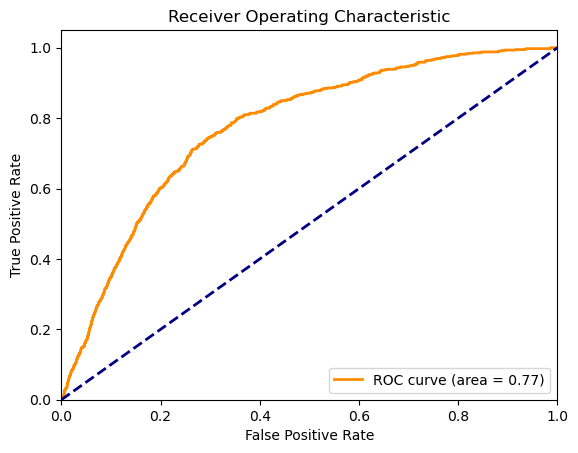

In [16]:
from Visualization_functions import plot_roc_curve, generate_visualizations
import numpy as np

y_pred_proba = np.array([pred[1] for pred in predictions])
y_pred = (y_pred_proba > 0.5).astype(int)

plot_roc_curve(y_validation, y_pred_proba, point_thresholds=None, point_tprs=None)
generate_visualizations(X_validation_processed,y_pred,y_validation,main_df,'Transformer_Visuals')

In [17]:
np.save("Transformer_validation_probabilities.npy", y_pred_proba)